# Project 3 - Adult Census Income

## 问题分析

### 问题定义

给定一个包含一系列个人信息的数据集，训练一个机器学习模型来根据个人信息预测其年收入是否超过 $\$50K$ 

### 数据解释

本项目所用数据集抽取自1994年美国人口普查数据库，共计32561条，其中22792条给出label用于训练，9769条用于测试。

数据集中样本含有以下特征信息：

|特征|含义|类型|
|-|-|-|
|age|工作年龄|连续|
|workclass|工作类型|离散|
|fnlwgt|代表数目|权重|
|education|学历|离散|
|education_num|学龄|连续|
|marital_status|婚姻状况|离散|
|occupation|职位|离散|
|relationship|家庭关系|离散|
|race|人种|离散|
|gender|性别|离散|
|capital_gain|资本利得|连续|
|capital_loss|资本损失|连续|
|hours_per_week|每周工时|连续|
|native_country|所处国家|离散|
|income|收入等级|标签|

（注：缺失值用`'?'`表示）

### 数据观察

为选择合适的模型和进行预处理，需要从经验的角度对数据先进行观察和统计。本数据集离散类型较多，且关系较为直观，猜测使用决策树相关模型效果较好（当然本项目尝试了大量其他模型）

#### 相关数据

根据经验及统计观察，$(workclass, occupation, hours_per_week), (education, education_num), (marital_status, relationship, gender)$ 三组内部存在明显相关性，后续选择特征和调参时应当注意。

#### 缺失处理

提出三种缺失值处理方案：
1. 删除存在缺失值的样本
2. 将缺失值看作特殊的离散值
3. 离散缺失值使用众数，连续缺省值使用平均数填充

由于本数据集中，缺失值仅出现在离散数据特征中，且集中 $workclass$, $occupation$ 中，且在训练集中占比略高于5%。方案1会损失近十分之一的训练数据，且无法估计测试集中缺失值；因缺失占比皆比较明显，方案3可能会造成明显误差。故此处使用方案二进行处理。


### 研究意义

在平时生活中，收入一般是比较私人的问题，不太可能进行直接询查，但是却可以较为容易地收集到上述相关数据，若能借此预测个人的收入水平，则可以在产品推广等有所运用。同时也可以通过该预测反向分析出致富与其他条件的关系，为人生发展提出参考意见

In [1]:
import pandas as pd
from sklearn import metrics
from sklearn.model_selection import cross_val_score
import optuna
import dtale

# read files
data_file = 'data/traindata.csv'
lable_file = 'data/trainlabel.txt'
judge_file = 'data/testdata.csv'
data_df = pd.read_csv(data_file)
judge_df = pd.read_csv(judge_file)
lable = []
with open(lable_file) as f:
    for line in f:
        lable.append(1 if line.strip() == '1' else 0)
data_df = data_df.join(pd.DataFrame(lable, columns=['label']))
dtale.show(data_df, open_browser=True)

## 数据处理

### 数据清洗与独热码

下一代码块中的注释部分展示了方案一的删去缺失样本操作，然而在采用方案三时，只需将其看作一种离散值的可能，在独热码转换时生成 `{*_?: 0, 1}` 的新特征即可

### 特征筛选

根据先前的观察分析以及尝试与调参，不同模型所需的特征不尽相同。（如 `sklearn.ensemble.RandomForestClassifier` 在删除 `['sex', 'native.country', 'race']` 时表现较佳）

### 数据划分

在提供的22792条训练数据中，以前20000条数据作为临时训练数据，后2792条作为评估数据。最终在选出最佳模型后在使用所有训练数据进行训练。

### 评估方式

以精确度：`sklearn.model_selection.cross_val_score(prediction, label, weight)` 作为评估函数，越大越优。

In [10]:
# deleting samples with missing data
# mask = data_df.isin(['?'])
# unkown = mask.any(axis=1)
# data_df.drop(data_df[unkown].index, inplace=True)
# data_df = data_df.reset_index(drop=True)
# lable = [lable[i] for i in range(len(lable)) if not unkown[i]]
# weight = data_df['fnlwgt'].to_list()[:20001]
# data_df.drop('fnlwgt', axis=1, inplace=True)
# data_df = pd.get_dummies(data_df)
# features = data_df.columns.tolist()

# covert discrete values into one-hot codes
# different models may need different convertion
dummies = pd.get_dummies(data_df.drop(columns=['sex', 'native.country', 'race']),
                         columns=['workclass', 'education', 'marital.status', 'occupation', 'relationship'])
train_df = dummies[:20001]
test_df = dummies[20000:]

## 最优模型

在尝试数个模型和调参之后，目前最优的模型为 `xgboost.XGBClassifier`

### 模型介绍

XGBoost是“Extreme Gradient Boosting”的缩写，将多个弱分类器加权转化为强分类器决策树，每个弱分类器结构较为简单，且相对独立进行梯度下降以防止过拟合，加权集合能够得到残差较小的优秀结果，可以视作为结合梯度优化的随机森林。XGBoost在子树分裂和惩罚剪枝处和其他决策树模型也有差异。

### 参数列表

|参数|数值|意义|
|-|-|-|
|n_estimators|111|弱分类器总数|
|max_depth|11|最大深度|
|min_child_weight|1459507|最小叶子权重|
|learning_rate|0.065082245687885|初始学习率|

（注：本模型拟合训练用数据预先删去了 $native.country$ 特征）

### 评估结果

$acc = 0.8774824681240023$

### 重要特征

下图列出了训练后计算的前10重要的特征

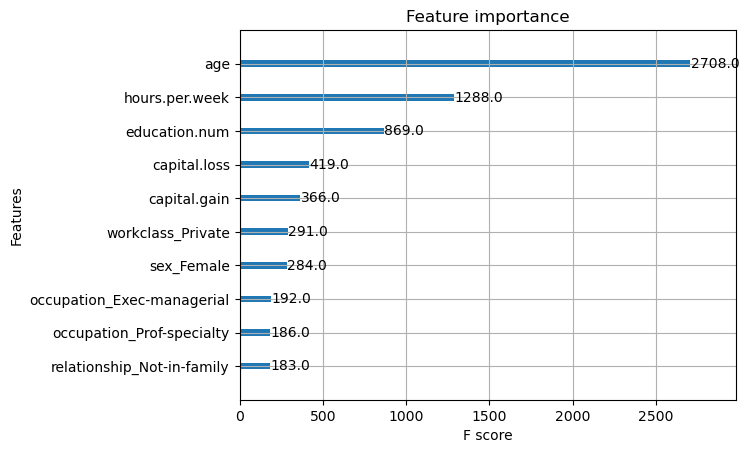

### 可视化树

由于优化调参后的树较大，结构略显复杂，嵌入文档可读性较差，可移步 `xgb_tree.pdf` 查看




In [238]:
from xgboost import XGBClassifier

dummies = pd.get_dummies(data_df.drop(columns=['native.country']),
                         columns=['workclass', 'education', 'marital.status', 'occupation', 'relationship', 'race', 'sex'])
train_df = dummies[:20001]
test_df = dummies[20000:]

xgb = XGBClassifier(n_estimators=111, max_depth=11, min_child_weight=1459507, learning_rate=0.065082245687885)
xgb.fit(train_df.drop(columns=['fnlwgt', 'label']), train_df['label'], sample_weight=train_df['fnlwgt'])
predictions = xgb.predict(test_df.drop(columns=['fnlwgt', 'label']))
print(metrics.accuracy_score(predictions, test_df['label'], sample_weight=test_df['fnlwgt']))

0.8774824681240023


## 参数调整

此处选取了特征种类、弱分类器总数、最大深度、最小叶子权重和初始学习率进行调整。其中特征种类手动调整，剩余参数借助工具自动调整。

### 工具介绍

采用 `optuna` 进行调参，其是一个自动超参数优化软件框架，且具备可视化（类似jupyter notebook）的功能，其采用网格搜索、遗传算法等进行搜寻参数的局部最优，且支持搜索空间、优化方向、交叉采样评估等自定义。

In [214]:
def objective(trial:optuna.Trial):
    n = trial.suggest_int('n', 60, 120)
    depth = trial.suggest_int('depth', 7, 16)
    min_weight = trial.suggest_int('min_weight', 1000000, 2000000)
    rate = trial.suggest_float('rate', 0.04, 0.3)
    
    clf = XGBClassifier(n_estimators=n, max_depth=depth, min_child_weight=min_weight, learning_rate=rate)
    # {'n': 70, 'depth': 9, 'min_weight': 1668735, 'rate': 0.14404510411349733}
    # {'n': 111, 'depth': 11, 'min_weight': 1459507, 'rate': 0.065082245687885}
    clf.fit(train_df.drop(columns=['fnlwgt', 'label']), train_df['label'], sample_weight=train_df['fnlwgt'])
    predictions = clf.predict(test_df.drop(columns=['fnlwgt', 'label']))
    return metrics.accuracy_score(predictions, test_df['label'], sample_weight=test_df['fnlwgt'])

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100, n_jobs=-1)
study.best_params, study.best_value

[I 2023-06-09 15:19:43,877] A new study created in memory with name: no-name-14969c5c-8931-4d22-9e1f-1cbef9c4969b
[I 2023-06-09 15:19:50,785] Trial 7 finished with value: 0.8701458554865356 and parameters: {'n': 81, 'depth': 8, 'min_weight': 1838685, 'rate': 0.19880608868732097}. Best is trial 7 with value: 0.8701458554865356.
[I 2023-06-09 15:19:53,780] Trial 14 finished with value: 0.868590302710741 and parameters: {'n': 90, 'depth': 10, 'min_weight': 1877446, 'rate': 0.2624088746095793}. Best is trial 7 with value: 0.8701458554865356.
[I 2023-06-09 15:19:54,132] Trial 4 finished with value: 0.866008238101813 and parameters: {'n': 63, 'depth': 13, 'min_weight': 1336309, 'rate': 0.21989434761818522}. Best is trial 7 with value: 0.8701458554865356.
[I 2023-06-09 15:19:57,400] Trial 3 finished with value: 0.8685013856606536 and parameters: {'n': 86, 'depth': 13, 'min_weight': 1079092, 'rate': 0.2415869847771571}. Best is trial 7 with value: 0.8701458554865356.
[I 2023-06-09 15:19:58,331

({'n': 89, 'depth': 10, 'min_weight': 1531450, 'rate': 0.12705124015089755},
 0.8759543950296478)

## 其余模型

本次项目还尝试了随机森林、多层感知机、朴素贝叶斯多种分类算法并进行了调参优化。
- 梯度提升树效果最好，且调参后，相对稳定，不那么容易过拟合
- 随机森林效果次之，但容易过拟合，需要通过多个参数进行限制
- 感知机效果也可以，但不便解释，调参过程也比较不明不白
- 贝叶斯效果随模型而异，对特征筛选很明敏感，但没有太多其他参数需要调整

### 评估结果
|模型|精确度|
|-|-|
|xgboost.XGBClassifier|0.8774824681240023|
|lightgbm.LGBMClassifier|0.8682676295335993|
|sklearn.ensemble.RandomForestClassifier|0.8657147606593278|
|sklearn.naive_bayes.CategoricalNB|0.8580999400285061|
|sklearn.neural_network.MLPClassifier|0.8580020469927475|
|sklearn.naive_bayes import GaussianNB|0.8404873438934974|
|sklearn.naive_bayes.BernoulliNB|0.8137840680915457|
|sklearn.naive_bayes.ComplementNB|0.7830331687688398|
|sklearn.naive_bayes.MultinomialNB|0.7830331687688398|

In [267]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=114, max_depth=45, min_samples_split=44, max_leaf_nodes=3994)
acc = 0
rf.fit(train_df.drop(columns=['fnlwgt', 'label']), train_df['label'], train_df['fnlwgt'])
predictions = rf.predict(test_df.drop(columns=['fnlwgt', 'label']))
print(metrics.accuracy_score(predictions, test_df['label'], sample_weight=test_df['fnlwgt']))

0.8657147606593278


In [256]:
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import CategoricalNB
from sklearn.naive_bayes import ComplementNB
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB

dummies = pd.get_dummies(data_df.drop(columns=['sex', 'native.country', 'race', 'marital.status', 'education']),
                         columns=['workclass', 'occupation', 'relationship'])
train_df = dummies[:20001]
test_df = dummies[20000:]

bnb = BernoulliNB()
bnb.fit(train_df.drop(columns=['fnlwgt', 'label']), train_df['label'], train_df['fnlwgt'])
predictions = bnb.predict(test_df.drop(columns=['fnlwgt', 'label']))
print(metrics.accuracy_score(predictions, test_df['label'], sample_weight=test_df['fnlwgt']))

canb = CategoricalNB()
canb.fit(train_df.drop(columns=['fnlwgt', 'label']), train_df['label'], train_df['fnlwgt'])
predictions = canb.predict(test_df.drop(columns=['fnlwgt', 'label']))
print(metrics.accuracy_score(predictions, test_df['label'], sample_weight=test_df['fnlwgt']))

conb = ComplementNB()
conb.fit(train_df.drop(columns=['fnlwgt', 'label']), train_df['label'], train_df['fnlwgt'])
predictions = conb.predict(test_df.drop(columns=['fnlwgt', 'label']))
print(metrics.accuracy_score(predictions, test_df['label'], sample_weight=test_df['fnlwgt']))

gnb = GaussianNB()
gnb.fit(train_df.drop(columns=['fnlwgt', 'label']), train_df['label'], train_df['fnlwgt'])
predictions = gnb.predict(test_df.drop(columns=['fnlwgt', 'label']))
print(metrics.accuracy_score(predictions, test_df['label'], sample_weight=test_df['fnlwgt']))

mnb = MultinomialNB()
mnb.fit(train_df.drop(columns=['fnlwgt', 'label']), train_df['label'], train_df['fnlwgt'])
predictions = mnb.predict(test_df.drop(columns=['fnlwgt', 'label']))
print(metrics.accuracy_score(predictions, test_df['label'], sample_weight=test_df['fnlwgt']))

0.8137840680915457
0.8580999400285061
0.7830331687688398
0.8404873438934974
0.7830331687688398


In [39]:
from sklearn.neural_network import MLPClassifier

dummies = pd.get_dummies(data_df.drop(columns=[]),
                         columns=['workclass', 'education', 'marital.status', 'occupation', 'relationship', 'race', 'sex', 'native.country'])
train_df = dummies[:20001]
test_df = dummies[20000:]

mlp = MLPClassifier(hidden_layer_sizes=(359,), alpha=0.00042062613323840626, batch_size=926, learning_rate_init=0.00015703156146915697, max_iter=99)
mlp.fit(train_df.drop(columns=['fnlwgt', 'label']), train_df['label'])
predictions = mlp.predict(test_df.drop(columns=['fnlwgt', 'label']))
print(metrics.accuracy_score(predictions, test_df['label'], sample_weight=test_df['fnlwgt']))

0.8580020469927475


In [236]:
from lightgbm import LGBMClassifier

dummies = pd.get_dummies(data_df.drop(columns=[]),
                         columns=['workclass', 'education', 'marital.status', 'occupation', 'relationship', 'race', 'sex','native.country'])
train_df = dummies[:20001]
test_df = dummies[20000:]

lgbm = LGBMClassifier(n_estimators=418, num_leaves=83, learning_rate=0.061944964921744644)
lgbm.fit(train_df.drop(columns=['fnlwgt', 'label']), train_df['label'], sample_weight=train_df['fnlwgt'])
predictions = lgbm.predict(test_df.drop(columns=['fnlwgt', 'label']))
print(metrics.accuracy_score(predictions, test_df['label'], sample_weight=test_df['fnlwgt']))

0.8682676295335993


## 反思展望

### 缺失值处理

本次并为尝试使用其他方案进行结果比对，未能排除方案三更优的可能性，也可以尝试排除单独训练缺失值特征的分类器等方案。


同时当前方案并不能防止遇到新的离散特征值，需要进一步处理输入数据。

### 特征筛选

本次对每一模型进行特征筛选时主要依靠经验和模型特性进行手动调参，后续可以尝试将特征组合映射到整数域（如二进制表示）从而利用工具进行自动调参，提高调参效率。

### 数据分析

一是训练之前，本次并未通过数理统计方法来分析特征之间相关性等，使得调参和筛选是显得有些盲目；二是训练之后，本次所采用的评估方案较为单一，未能统计训练/预测效率、PR、ROC、AUC等，也无法体现出鲁棒性。


故日后需要学习利用跟科学的方式对取得、生成的数据进行分析，这样调参时放冷知其然而知其所以然，也使结果有理有据，更具说服力。